In [1]:
library(ggplot2)
library(data.table)
theme_set(theme_bw())

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘data.table’ was built under R version 4.2.3”


In [2]:
tools = c('singlem', 'metaphlan', 'motus', 'kraken', 'sourmash', 'kaiju', 'map2b', 'metabuli')
# Tools that do not have the correct taxonomy are tested only at the domain level. eg. Kaiju has NCBI taxonomy and MAP2B uses GTDB v202, mOTUs sometimes has incompatible strings
correct_taxonomy_tools = c('singlem', 'metaphlan', 'kraken', 'sourmash', 'metabuli')

publication_names = data.table(
    tool = tools,
    publication_name = c('SingleM', 'MetaPhlAn', 'mOTUs', 'Kraken2', 'sourmash', 'Kaiju', 'MAP2B', 'Metabuli')
)
name_to_publication_name = function(names, correct_taxonomy_only=F){
    to_return = c()
    for (name in names){
        to_return = c(to_return, publication_names[tool==name]$publication_name)
    }
    if (correct_taxonomy_only){
        return(factor(to_return, levels=publication_names[tool %in% correct_taxonomy_tools]$publication_name))
    } else {
        return(factor(to_return, levels=publication_names$publication_name))
    }
}

In [3]:
setwd('~/m/msingle/mess/124_singlem-benchmarking/1_novel_strains/')
base_dir = './'
# base_dir = 'full_run8/checkout/1_novel_strains/' # Directory created when run in local scratch through queuing system

In [4]:
communities = gsub('^','marine',as.character(0:9))
# communities = gsub('^','marine',as.character(6)) # debug
communities

[1] "marine0" "marine1" "marine2" "marine3" "marine4" "marine5" "marine6"
 [8] "marine7" "marine8" "marine9"

In [5]:
d1 = data.table(expand.grid(correct_taxonomy_tools, communities))
setnames(d1, c('tool', 'community'))
d1[1:3]

tool,community
<fct>,<fct>
singlem,marine0
metaphlan,marine0
kraken,marine0


In [6]:
# output_singlem/opal/GCA_022615805.1_genomic.opal_report
readit = function(tool, community){
    to_read = paste(base_dir,'output_',tool,sep='','/opal/',community,'.opal_report')
    # print(to_read)
    return(fread(to_read))
}
d2 = d1[, readit(tool, community), by=list(tool,community)]
d2[1:3]

tool,community,tool,rank,metric,sample,value
<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>
singlem,marine0,Gold standard,kingdom,Bray-Curtis distance,SAMPLEID,0
singlem,marine0,Gold standard,phylum,Bray-Curtis distance,SAMPLEID,0
singlem,marine0,Gold standard,class,Bray-Curtis distance,SAMPLEID,0


In [7]:
dim(d2)

[1] 9100    7

In [8]:
setnames(d2, c('tool','community','blah','rank','metric','sample','value'))
d3 = d2[blah != 'Gold standard'][,.(tool, community, rank, metric, value)]
d3[1:3]
dim(d3)

tool,community,rank,metric,value
<fct>,<fct>,<chr>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.001059099
singlem,marine0,phylum,Bray-Curtis distance,0.023300362
singlem,marine0,class,Bray-Curtis distance,0.033351204


[1] 4550    5

In [9]:
bc = d3[metric=='Bray-Curtis distance']
dim(bc)
bc[1:10]

[1] 350   5

tool,community,rank,metric,value
<fct>,<fct>,<chr>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.001059099
singlem,marine0,phylum,Bray-Curtis distance,0.023300362
singlem,marine0,class,Bray-Curtis distance,0.033351204
singlem,marine0,order,Bray-Curtis distance,0.051062981
singlem,marine0,family,Bray-Curtis distance,0.063034811
singlem,marine0,genus,Bray-Curtis distance,0.079041847
singlem,marine0,species,Bray-Curtis distance,0.156473757
metaphlan,marine0,kingdom,Bray-Curtis distance,0.000000000
metaphlan,marine0,phylum,Bray-Curtis distance,0.055800549


In [10]:
orders = c('kingdom','phylum','class','order','family','genus','species')
bc[, rank := factor(rank, levels=orders)]
bc[1:3]

tool,community,rank,metric,value
<fct>,<fct>,<fct>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.001059099
singlem,marine0,phylum,Bray-Curtis distance,0.023300362
singlem,marine0,class,Bray-Curtis distance,0.033351204


In [11]:
average_bc = bc[tool %in% correct_taxonomy_tools][, mean(value), by=list(tool)][order(V1)]
average_bc

tool,V1
<fct>,<dbl>
singlem,0.06382103
metaphlan,0.15201288
kraken,0.17657249
sourmash,0.18240201
metabuli,0.34245861


In [12]:
bcc = bc[tool %in% correct_taxonomy_tools]
bcc[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”
Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“Removed 10 rows containing non-finite values (`stat_boxplot()`).”


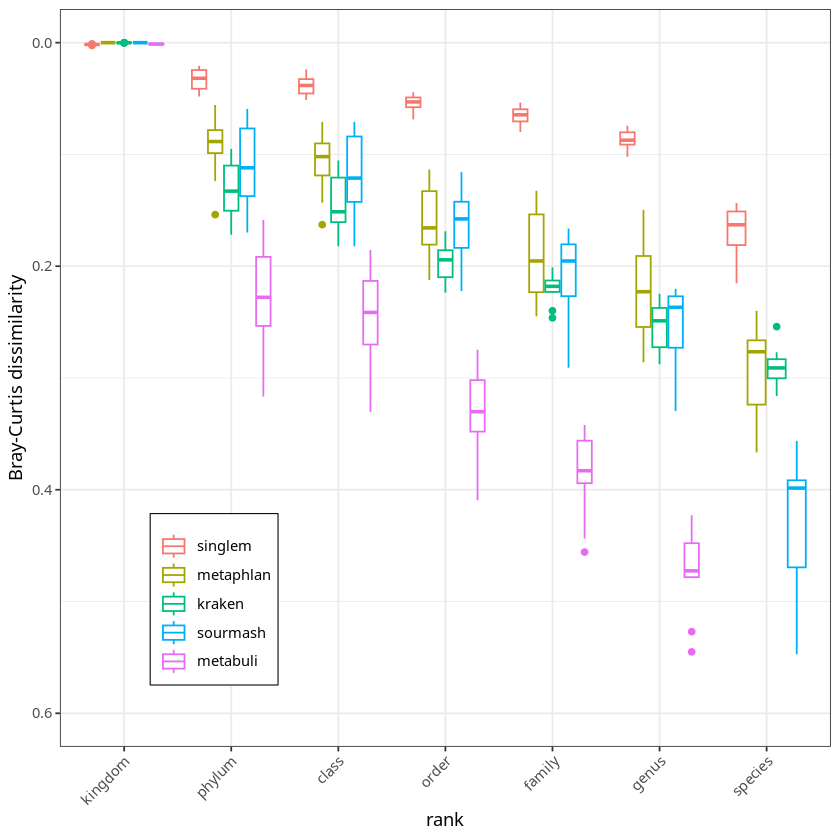

In [13]:

# Remove figure legend title, and put the legend in bottom left of plot, with a bounding box
qplot(data=bcc, rank, value, ylim=c(0.6,0), geom='boxplot', colour=tool, ylab='Bray-Curtis dissimilarity') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.title=element_blank()) + theme(legend.position=c(0.2,0.2)) + theme(legend.background = element_rect(colour = "black", size = 0.3))

In [14]:
# How much better is singlem than the next best tool?
means = bcc[rank=='species', mean(value), by=tool][order(-V1)]
means
means[tool=='singlem', V1] - means[tool!='singlem', min(V1)]

tool,V1
<fct>,<dbl>
metabuli,0.7354544
sourmash,0.4280521
metaphlan,0.2920807
kraken,0.2902896
singlem,0.1679767


[1] -0.1223129

In [15]:
# write out bc
fwrite(bcc, 'bray-curtis.csv', sep='\t')

# Runtime comparison

In [16]:
# thread_numbers = as.character(c(1,8,32))
thread_numbers = as.character(c(1))

In [17]:
# DEBUG - set to 32 threads so to get a preliminary answer
thread_numbers = c(32)

In [18]:
r1 = data.table(expand.grid(tools, thread_numbers, communities))
setnames(r1, c('tool', 'threads', 'community'))
r1 = r1[tool != 'coverm' | threads == '32']
r1[1:3]

tool,threads,community
<fct>,<dbl>,<fct>
singlem,32,marine0
metaphlan,32,marine0
motus,32,marine0


In [19]:
r1[tool=='kracken', tool := 'kraken']
reed = function(tool,threads,community){
    # print(x)
    # f = paste(base_dir,'benchmarks/',x$tool,'/',x$community,'-',x$threads,'threads.benchmark',sep='')
    f = paste(base_dir,'benchmarks/',tool,'/',community,'-',threads,'threads.benchmark',sep='')
    # print(f)
    return(fread(f))
}
r2 = r1[, reed(tool,threads,community), by=list(tool,threads,community)]
getwd()
r2[1:3]

[1] "/mnt/hpccs01/work/microbiome/msingle/mess/124_singlem-benchmarking/1_novel_strains"

tool,threads,community,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time
<fct>,<dbl>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
singlem,32,marine0,427.4104,0:07:07,2583.36,37164.16,2550.39,2565.34,2841.27,588.59,648.42,2778.39
metaphlan,32,marine0,548.2910,0:09:08,18007.67,56891.99,17982.98,17991.67,496.00,111.39,2668.74,14636.14
motus,32,marine0,1043.0282,0:17:23,9103.10,19646.79,9087.18,9087.24,468.22,0.01,1001.89,117.05


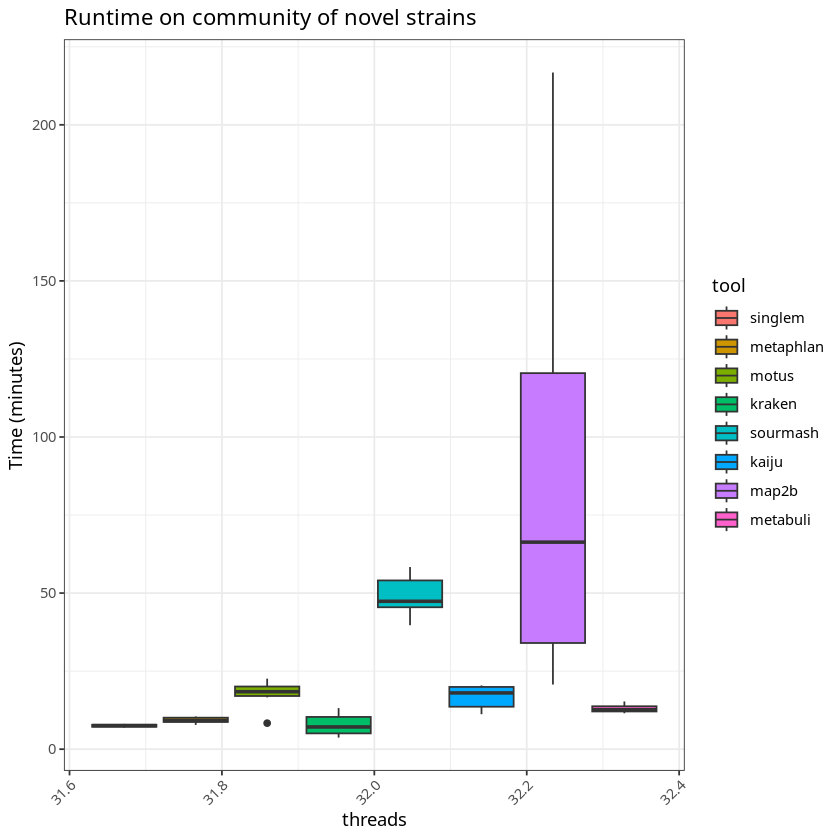

In [20]:
qplot(data=r2, threads, s/60, geom='boxplot', fill=tool, ylab='Time (minutes)', main='Runtime on community of novel strains') + theme(axis.text.x = element_text(angle = 45, hjust = 1))

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


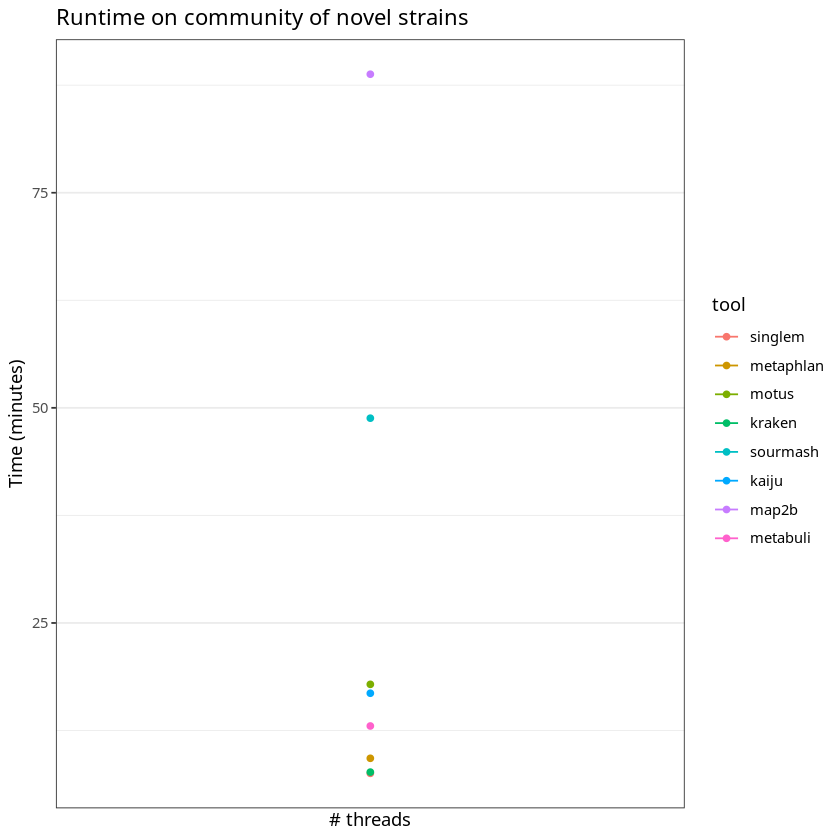

In [21]:
r3 = r2[, .(mean_s = mean(s)), by=list(tool,threads)]
# r3
qplot(data=r3, as.numeric(threads), mean_s/60, geom='point', ylab='Time (minutes)', xlab='# threads', main='Runtime on community of novel strains', colour=tool)+geom_line()+scale_x_continuous(breaks=c(1,2,3), labels=c(1,8,32))

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


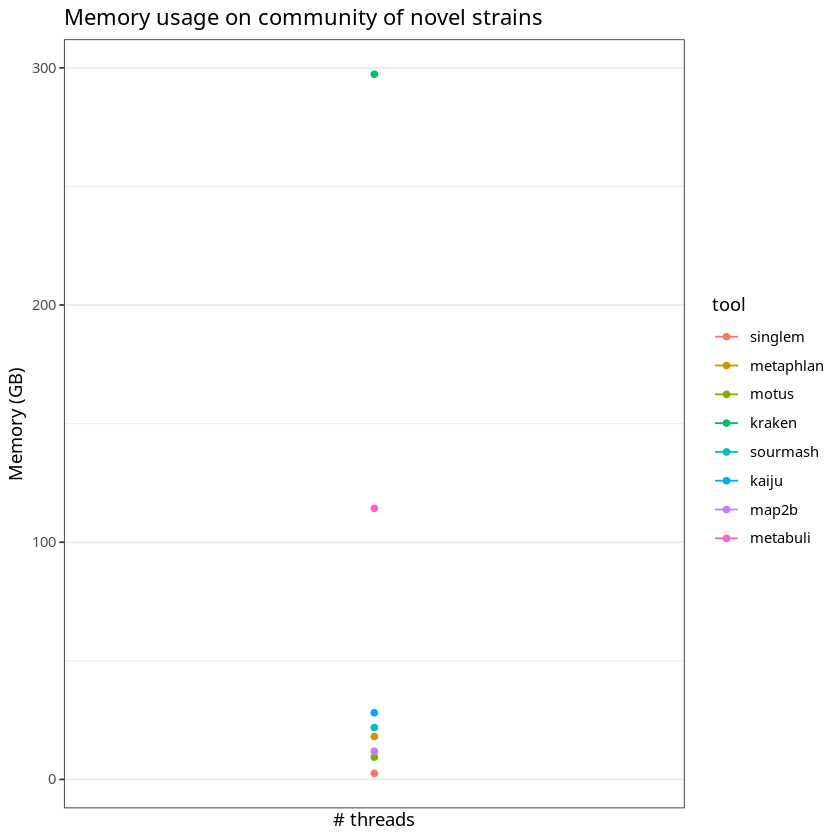

In [22]:
# RAM
r4 = r2[, .(mean_mem = mean(max_rss)), by=list(tool,threads)]
qplot(data=r4, as.numeric(threads), mean_mem/1000, geom='point', ylab='Memory (GB)', xlab='# threads', main='Memory usage on community of novel strains', colour=tool)+geom_line()+scale_x_continuous(breaks=c(1,2,3), labels=c(1,8,32))

In [23]:
r4

tool,threads,mean_mem
<fct>,<dbl>,<dbl>
singlem,32,2564.044
metaphlan,32,18095.253
motus,32,9391.130
kraken,32,297322.092
sourmash,32,21861.358
kaiju,32,28108.559
map2b,32,11885.997
metabuli,32,114284.744


In [24]:
## Commented out because it takes a while to run

# Reads per minute
# read_counts = data.table(community=communities)
# read_counts2 = read_counts[, fread(cmd=paste('zcat local_reads/',community,'.1.fq.gz | wc -l',sep='')), by=community]
# read_counts2

# rcm = merge(r2[threads==1], read_counts2, by='community')
# rcm[, rpm := (V1/4)/s*60 *2] # times 2 because we only have half the reads in count
# rcm[1:3]

In [25]:
# Write rc3
fwrite(r2, 'runtime.csv', sep='\t')

# Full set of stats of each method

In [26]:
s1 = dcast(d3, tool+rank~metric, value.var='value', fun.aggregate=mean)

s1 = s1[tool %in% correct_taxonomy_tools]
s1[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]
s1[, tool := tool2]
s1[, tool2 := NULL]

# dcast(d3[metric %in% non_ranked_metrics], tool~metric, value.var='value', fun.aggregate=mean)

s1[, rank := factor(rank, levels=orders)]
s1 = s1[order(rank, tool)]
s1[1:3]
fwrite(s1, 'opal_summary.csv', sep='\t')

tool,rank,Bray-Curtis distance,Completeness,F1 score,False negatives,False positives,Jaccard index,L1 norm error,Purity,Shannon diversity,Shannon equitability,Sum of abundances,Taxon counts,True positives,Unweighted UniFrac (CAMI),Unweighted UniFrac error,Weighted UniFrac (CAMI),Weighted UniFrac error
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SingleM,kingdom,0.001625398,1,0.6666667,0,1,0.5,0.003250796,0.5,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
MetaPhlAn,kingdom,0.000000000,1,1.0000000,0,0,1.0,0.000000000,1.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
Kraken2,kingdom,0.000102000,1,0.6666667,0,1,0.5,0.000204000,0.5,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN


# Relationship between relative abundance and accuracy

In [27]:
base = base_dir #'/mnt/hpccs01/work/microbiome/msingle/mess/124_singlem-benchmarking/1_novel_strains/full_run1/checkout/1_novel_strains/'
# base = './'

truth_profiles = data.table(community=communities)
truth_profiles2 = truth_profiles[, fread(paste(base,'/truths/',community,'.condensed',sep='')), by=community]
truth_profiles2[, sample := NULL]
setnames(truth_profiles2, 'coverage', 'true_coverage')

tool_profiles = data.table(expand.grid(correct_taxonomy_tools, communities))
setnames(tool_profiles, c('tool','community'))
tool_profiles2 = tool_profiles[, fread(paste(base,'/output_',tool,'/',tool,'/',community,'.profile',sep='')), by=list(tool,community)]
tool_profiles2[, sample := NULL]
setnames(tool_profiles2, 'coverage', 'tool_coverage')
tool_profiles2[, taxonomy := gsub('Root;','',gsub('; ',';',taxonomy))]

# Kraken has filled profiles, so remove all except species annotations
tool_profiles3 = rbind(
    tool_profiles2[tool != 'kraken'],
    tool_profiles2[tool == 'kraken' & taxonomy %like% 's__']
)
tool_profiles3[tool=='kraken'][1:5]
# cartesian product so the all = T works for each tool
community_tool = data.table(expand.grid(tools, communities))
setnames(community_tool, c('tool','community'))
truth_profiles3 = merge(truth_profiles2, community_tool, all=T, allow.cartesian=T)
# truth_profiles3

m = merge(truth_profiles3, tool_profiles3, by=c('taxonomy','community','tool'), all=T)

m[is.na(tool_coverage), tool_coverage := 0]
m[is.na(true_coverage), true_coverage := 0]

tool,community,tool_coverage,taxonomy
<fct>,<fct>,<dbl>,<chr>
kraken,marine0,0.11258,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Pantoea;s__Pantoea stewartii
kraken,marine0,0.00114,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Pantoea;s__Pantoea ananatis
kraken,marine0,0.00088,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Pantoea;s__Pantoea allii
kraken,marine0,0.00026,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Pantoea;s__Pantoea deleyi
kraken,marine0,0.00010,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Pantoea;s__Pantoea dispersa


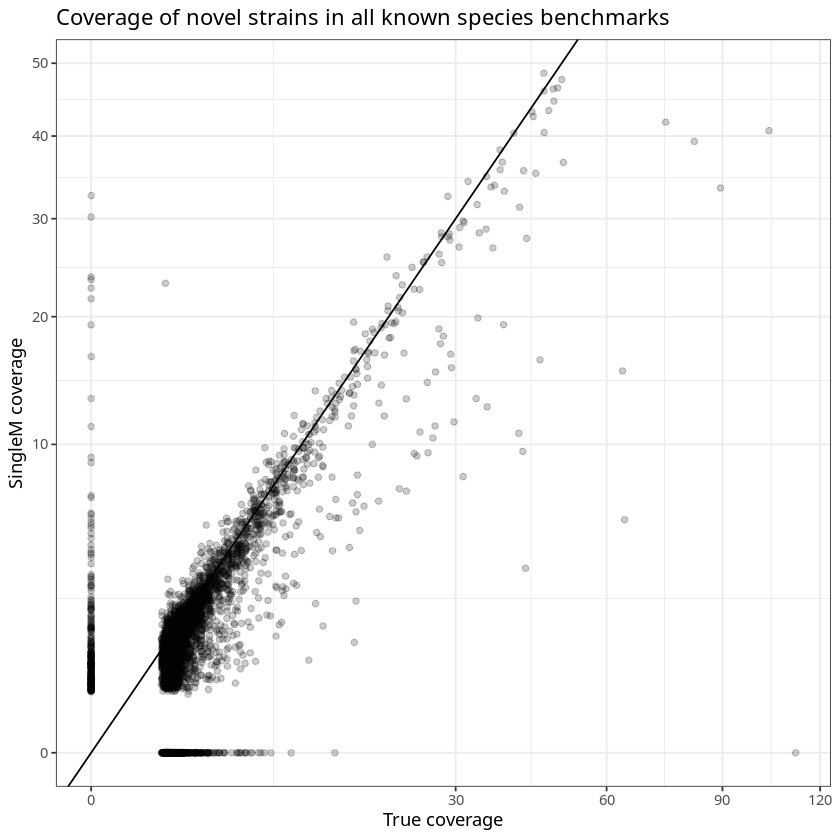

In [28]:
# Just for SingleM
qplot(data=m[tool=='singlem' & tool_coverage < 50][grep('s__',taxonomy)], true_coverage, tool_coverage, geom='point', xlab='True coverage', ylab='SingleM coverage', main='Coverage of novel strains in all known species benchmarks', alpha=I(1/5)) + geom_abline(intercept=0, slope=1)+scale_x_sqrt()+scale_y_sqrt()

In [29]:
m[tool=='kraken'][grep('s__',taxonomy)][community=='marine6'][order(-tool_coverage)][1:3]

taxonomy,community,tool,true_coverage,tool_coverage
<chr>,<fct>,<fct>,<dbl>,<dbl>
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides sp902362375,marine6,kraken,73.2114,0.05759
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__CAG-95;s__CAG-95 sp018384375,marine6,kraken,115.7030,0.04700
d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;g__Bradyrhizobium;s__Bradyrhizobium diversitatis,marine6,kraken,63.7534,0.03374


In [30]:
# All tools
# First convert to relabund
m[, tool_coverage_relabund := tool_coverage/sum(tool_coverage)*100, by=list(tool, community)]
m[, true_coverage_relabund := true_coverage/sum(true_coverage)*100, by=list(tool, community)]

m = m[tool %in% correct_taxonomy_tools]
m[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]

original_width_height = c(getOption('repr.plot.width'), getOption('repr.plot.height'))
options(repr.plot.width=8, repr.plot.height=10)
qplot(data=m[grep('s__',taxonomy)], true_coverage_relabund, tool_coverage_relabund, geom='point', xlab='True relative abundance (%)', ylab='Predicted relative abundance (%)', alpha=I(1/10)) + geom_abline(intercept=0, slope=1, colour='red')+scale_x_sqrt()+scale_y_sqrt()+facet_wrap(~tool2, ncol=2, scales='free')
options(repr.plot.width=original_width_height[1], repr.plot.height=original_width_height[2])

In [ ]:
# What's with the 20+ coverage genome?

# marine0 = fread(paste(base,'truths/marine0.condensed',sep=''))
# marine0[, sample := 'marine0']
# setnames(marine0, 'coverage', 'true_coverage')
# singlem_marine0 = fread(paste(base,'output_singlem/singlem/marine0.profile',sep=''))
# setnames(singlem_marine0, 'coverage', 'singlem_coverage')
# singlem_marine0[, taxonomy := gsub('Root;','',gsub('; ',';',taxonomy))]
# # singlem_marine0[grep('s__',taxonomy)][1:3]

# m[true_coverage > 20 & singlem_coverage ==0]
# singlem_marine0[grep('g__Pseudomonas_E',taxonomy)]
# # => So it backed off to species level for some reason. Unsure why.

In [ ]:
# Fraction of genomes which were missed at each binned coverage levels
# m[, .(missed = sum(singlem_coverage==0)/.N*100, .N), by=.(cut(true_coverage, breaks=c(0,2,4,6,8,10,20,40,1000)))][order(cut)]

In [ ]:
# How well does genus level rescue some of the missing genomes? First need to remake the table with genus level, annoying since kraken profiles are filled, when the rest aren't.

# Kraken has filled profiles, so remove all except species annotations
tool_profiles3_genus = rbind(
    tool_profiles2[tool != 'kraken'],
    tool_profiles2[tool == 'kraken' & taxonomy %like% 'g__']
)
tool_profiles3_genus[tool=='kraken'][1:5]

m_genus = merge(truth_profiles3, tool_profiles3_genus, by=c('taxonomy','community','tool'), all=T)

m_genus[is.na(tool_coverage), tool_coverage := 0]
m_genus[is.na(true_coverage), true_coverage := 0]

m_genus[1:3]

m_genus[, genus_and_up := gsub(';s__.*','',taxonomy)]

# m[grep('g__',taxonomy)][1:10]
m2_genus = m_genus[, .(tool_coverage=sum(tool_coverage), true_coverage=sum(true_coverage)), by=.(community, genus_and_up, tool)]

m2_genus[grep('g__',genus_and_up)][tool=='kraken' & true_coverage > 0][1:3]

tool,community,tool_coverage,taxonomy
<fct>,<fct>,<dbl>,<chr>
kraken,marine0,0.11661,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Pantoea
kraken,marine0,0.01497,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Yersinia
kraken,marine0,0.00480,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Providencia
kraken,marine0,0.00291,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Proteus
kraken,marine0,0.00277,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Dickeya


taxonomy,community,tool,true_coverage,tool_coverage
<chr>,<fct>,<fct>,<dbl>,<dbl>
d__Archaea,marine0,singlem,0,1.6100
d__Archaea,marine0,metabuli,0,0.0914
d__Archaea,marine1,singlem,0,2.2300


community,genus_and_up,tool,tool_coverage,true_coverage
<fct>,<chr>,<fct>,<dbl>,<dbl>
marine6,d__Bacteria;p__Acidobacteriota;c__Acidobacteriae;o__Acidobacteriales;f__SbA1;g__Gp1-AA124,kraken,2e-05,3.84411
marine0,d__Bacteria;p__Acidobacteriota;c__Acidobacteriae;o__Acidobacteriales;f__SbA1;g__Gp1-AA124,kraken,0e+00,1.83878
marine1,d__Bacteria;p__Acidobacteriota;c__Acidobacteriae;o__Acidobacteriales;f__SbA1;g__Gp1-AA124,kraken,0e+00,1.67182


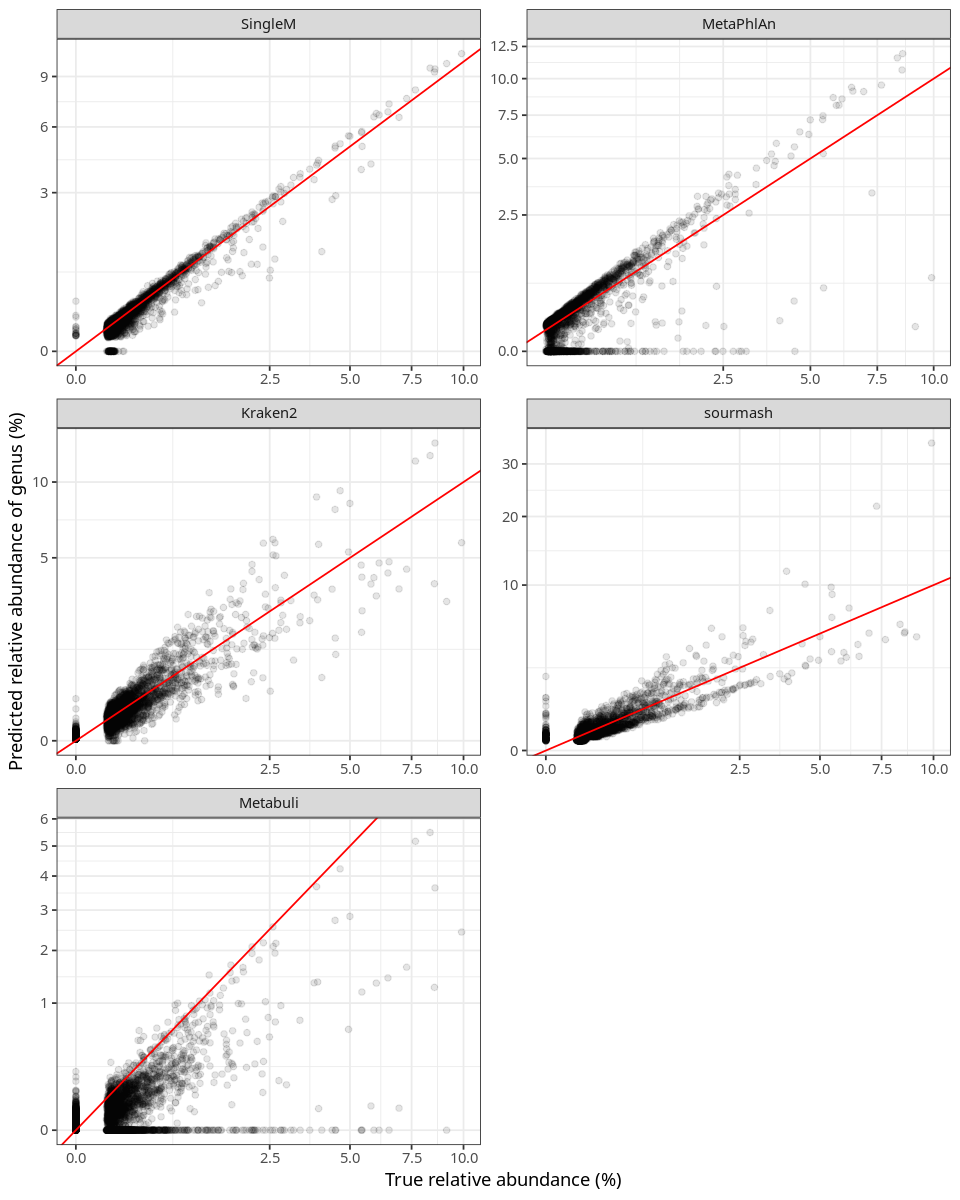

In [ ]:
m2_genus[, tool_coverage_relabund := tool_coverage/sum(tool_coverage)*100, by=list(tool, community)]
m2_genus[, true_coverage_relabund := true_coverage/sum(true_coverage)*100, by=list(tool, community)]

m2_genus = m2_genus[tool %in% correct_taxonomy_tools]
m2_genus[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]

original_width_height = c(getOption('repr.plot.width'), getOption('repr.plot.height'))
options(repr.plot.width=8, repr.plot.height=10)
qplot(data=m2_genus[grep('g__',genus_and_up)], true_coverage_relabund, tool_coverage_relabund, geom='point', xlab='True relative abundance (%)', ylab='Predicted relative abundance of genus (%)', alpha=I(1/10)) + geom_abline(intercept=0, slope=1, colour='red')+scale_x_sqrt()+scale_y_sqrt()+facet_wrap(~tool2, ncol=2, scales='free')
options(repr.plot.width=original_width_height[1], repr.plot.height=original_width_height[2])

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


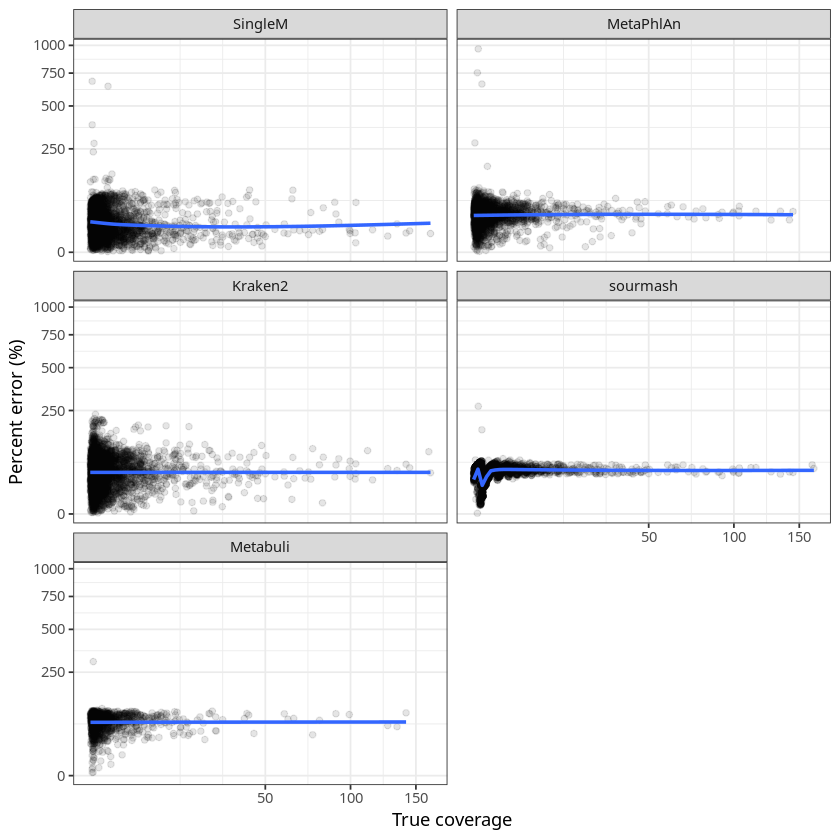

In [ ]:
# Percent error at the species level for each tool
m_error = m[true_coverage>0 & tool_coverage>0]
m_error[, error := abs(true_coverage_relabund - tool_coverage_relabund)/true_coverage_relabund*100]

qplot(data=m_error, true_coverage, error, geom='point', xlab='True coverage', ylab='Percent error (%)', alpha=I(1/10))+scale_x_sqrt()+scale_y_sqrt()+facet_wrap(~tool2, ncol=2)+geom_smooth(se=F)

# What fraction of singlem profiles are assigned to the species level?

In [ ]:
# m
assigned = m[tool2=='SingleM'][,sum(.SD[grep('s__',taxonomy)]$tool_coverage_relabund),by=community]
assigned
mean(assigned$V1)
sd(assigned$V1)

community,V1
<fct>,<dbl>
marine0,86.54958
marine1,82.80475
marine2,86.98378
marine3,82.10226
marine4,87.36950
marine5,77.71834
marine6,83.17924
marine7,86.61686
marine8,77.00437


[1] 83.42192

[1] 3.717478

# How many species are in each gold standard?

In [ ]:
coverages = data.table(number=0:9)
coverages2 = coverages[, fread(paste('coverage_definitions/coverage',number,'.tsv',sep='')), by=number]
setnames(coverages2, c('number','genome','coverage'))
mean(coverages2[grep('Otu',genome)][coverage>0][,.N,by=number]$N)
coverages2[grep('Otu',genome)][coverage>0]

[1] 469.4

number,genome,coverage
<int>,<chr>,<dbl>
0,Otu520.0,2.12834
0,Otu634.0,1.83878
0,Otu483,2.42345
0,Otu2487,1.56681
0,Otu2446,1.33722
0,Otu980,3.43963
0,Otu1219,1.34402
0,Otu2448,2.10658
0,Otu489.0,1.57037
